In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.signal import correlate, fftconvolve
from scipy.stats import kendalltau, spearmanr, pearsonr

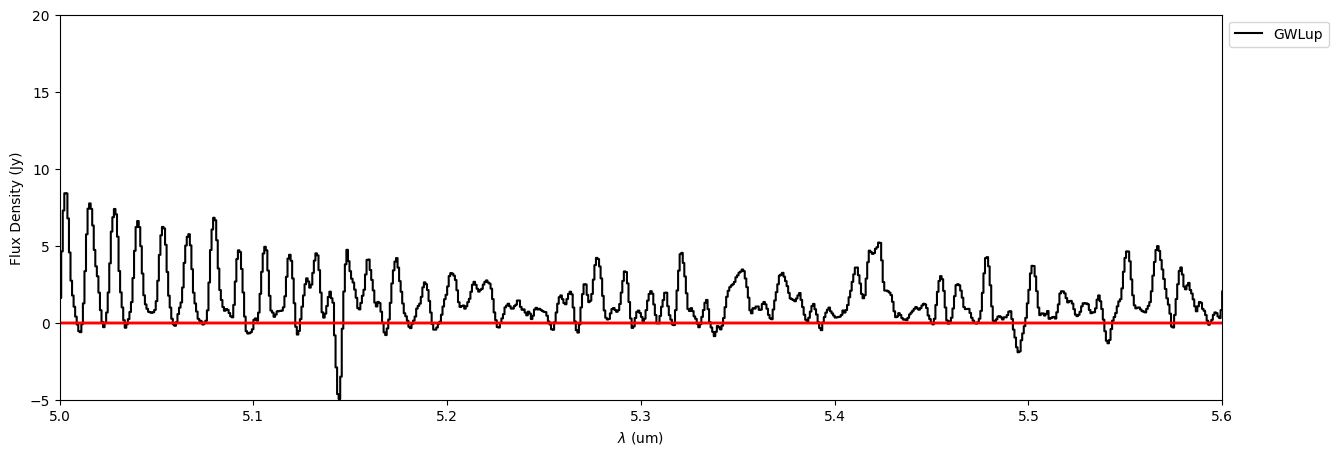

10657


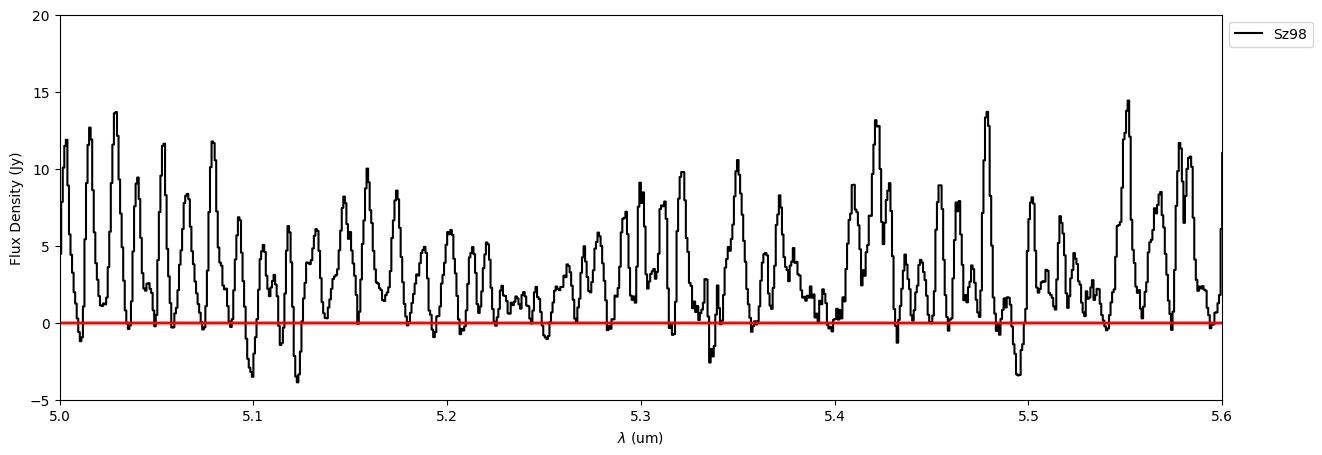

10657


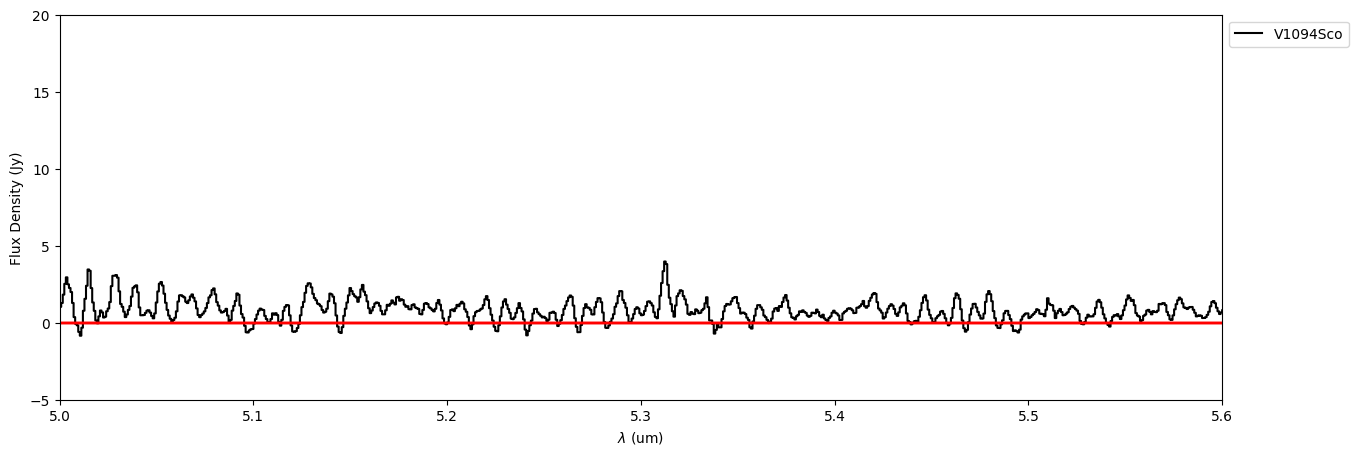

10657


In [8]:
features_df = pd.read_csv("matthias_linelist_combined.csv")

# Wavelength grid
clip_min, clip_max = 5, 5.6
feature_mask = np.logical_and(features_df['wavelength'] > clip_min, features_df['wavelength'] < clip_max)

species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']

# fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']
    ax1.step(wavelength, np.convolve(flux_cont_sub, np.ones(5)/5, mode='same')*1000, color='black',where='mid', label=f'{Source}')
    for index, row in features_df[feature_mask].iterrows():
        if row['type'] == 'hydrogen':
            color = 'purple'
            offset = 0.05
        elif row['type'] == 'fine_structure':
            color = 'orange'
            offset = 0.4
        elif row['type'] == 'molecular':
            color = 'blue'
            offset = 0.05
        else:
            color = 'red'
            offset = 0.6
        ax1.axhline(0,  color='red')
        # ax1.axvline(row['wavelength'], linestyle='--', alpha=0.3, color=color)
        # ax1.text(row['wavelength']+0.004, offset, row['name'], transform=ax1.get_xaxis_text1_transform(0)[0], color=color, rotation=90)

    # for specie in species:
    #     ax1.plot(total_wl, avg_flux[specie], alpha=0.7, label=specie)

    # plot decorations
    # ax1.set_xticks([14.9, 14.95, 15])
    ax1.set_xlim(clip_min, clip_max)    
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_xlabel(r'$\lambda$ (um)')
    ax1.set_ylim(-5, 20)
    
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    print(len(wavelength))

In [79]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [80]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
avg_flux = {}
total_wl = wavelength
for specie in species:
    total_flux = np.zeros_like(total_wl)
    for i,row in df.iterrows():
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(total_wl, specie_wl, specie_flux)
        total_flux += specie_flux
    total_flux /= 25
    avg_flux.update({specie:total_flux})

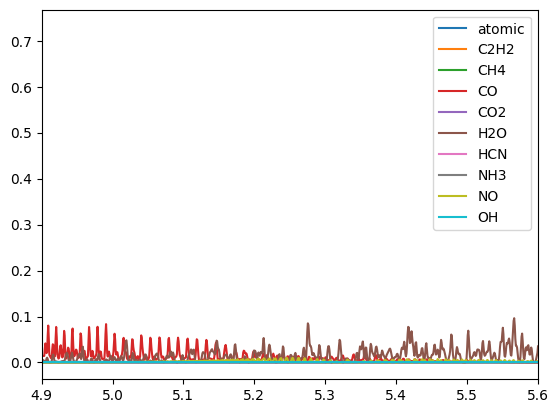

In [81]:
for specie in species:
    plt.plot(total_wl, avg_flux[specie], label=specie)
plt.legend()
plt.xlim(4.9, 5.6)
plt.show()

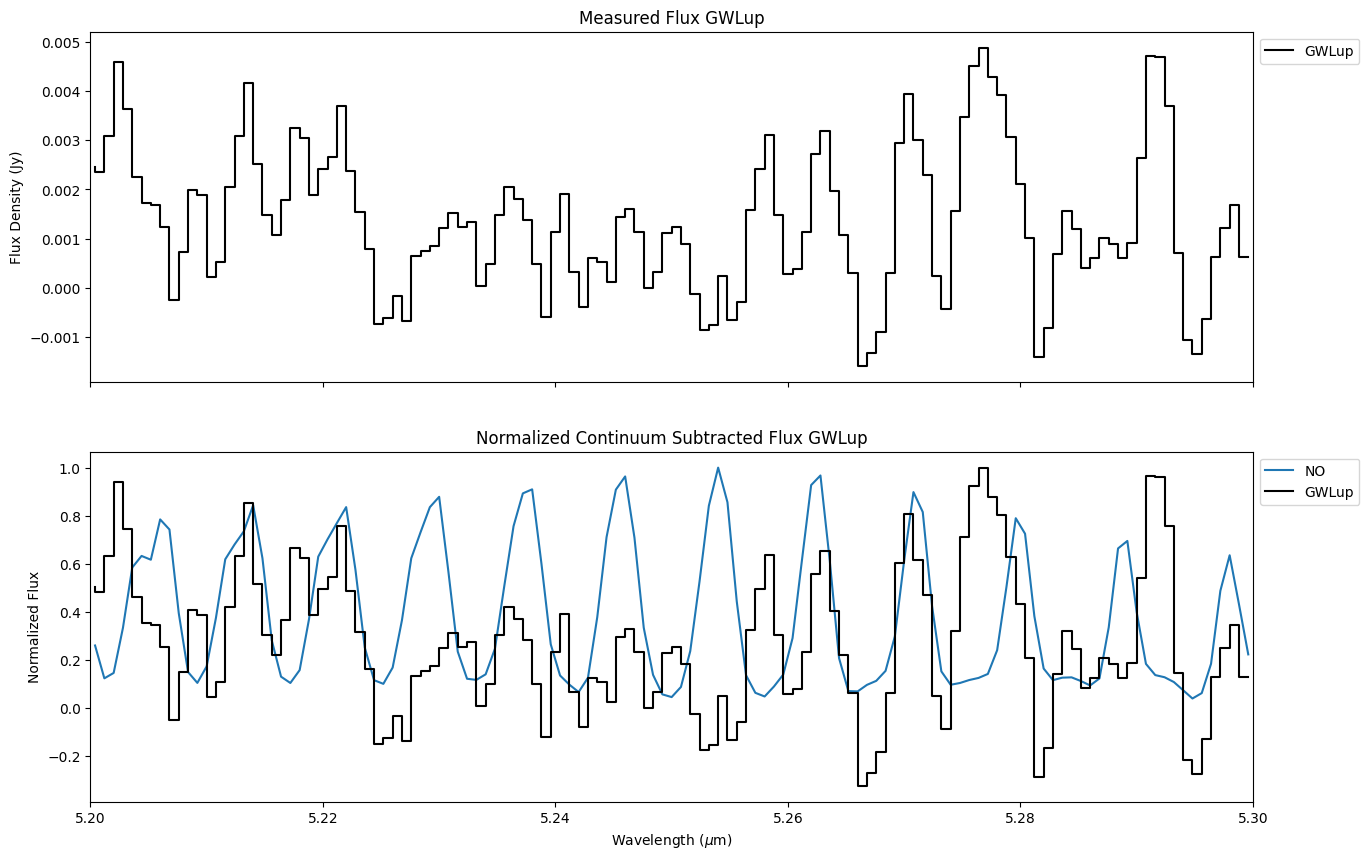

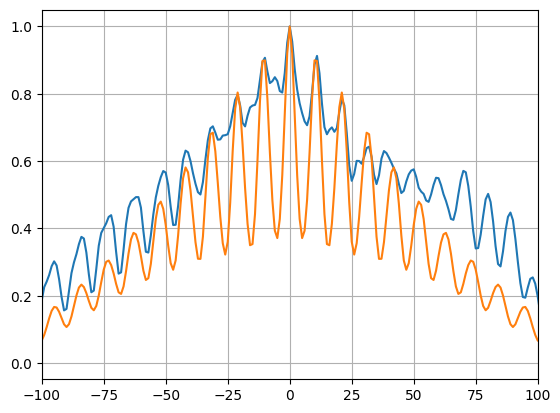

PearsonRResult(statistic=np.float64(0.9052887416744135), pvalue=np.float64(8.104739680361273e-94))


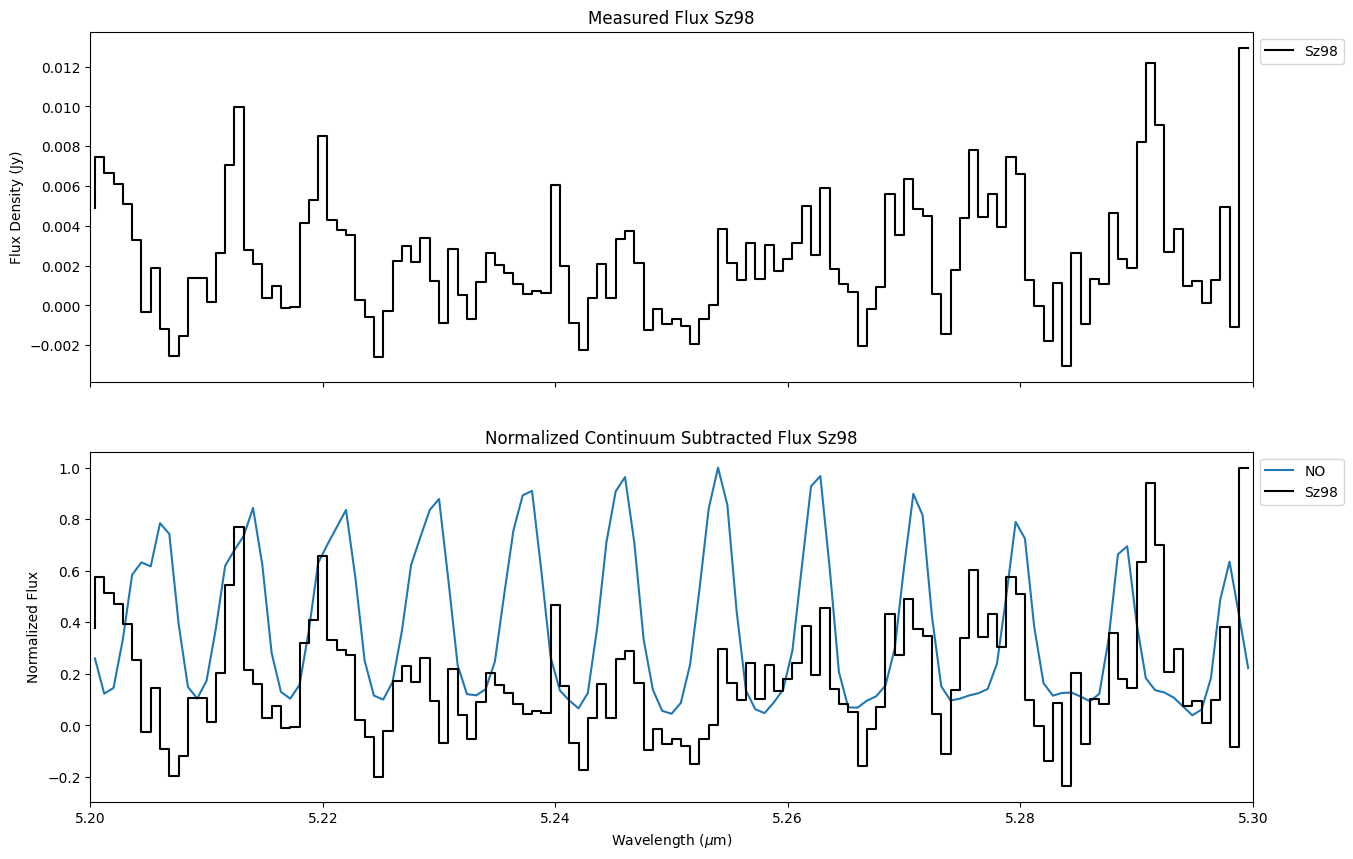

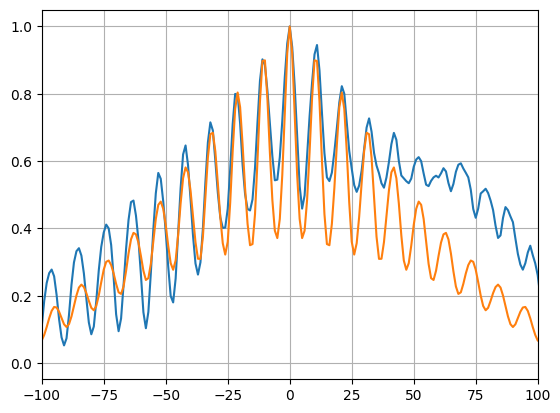

PearsonRResult(statistic=np.float64(0.8986121198623984), pvalue=np.float64(2.384064280211842e-90))


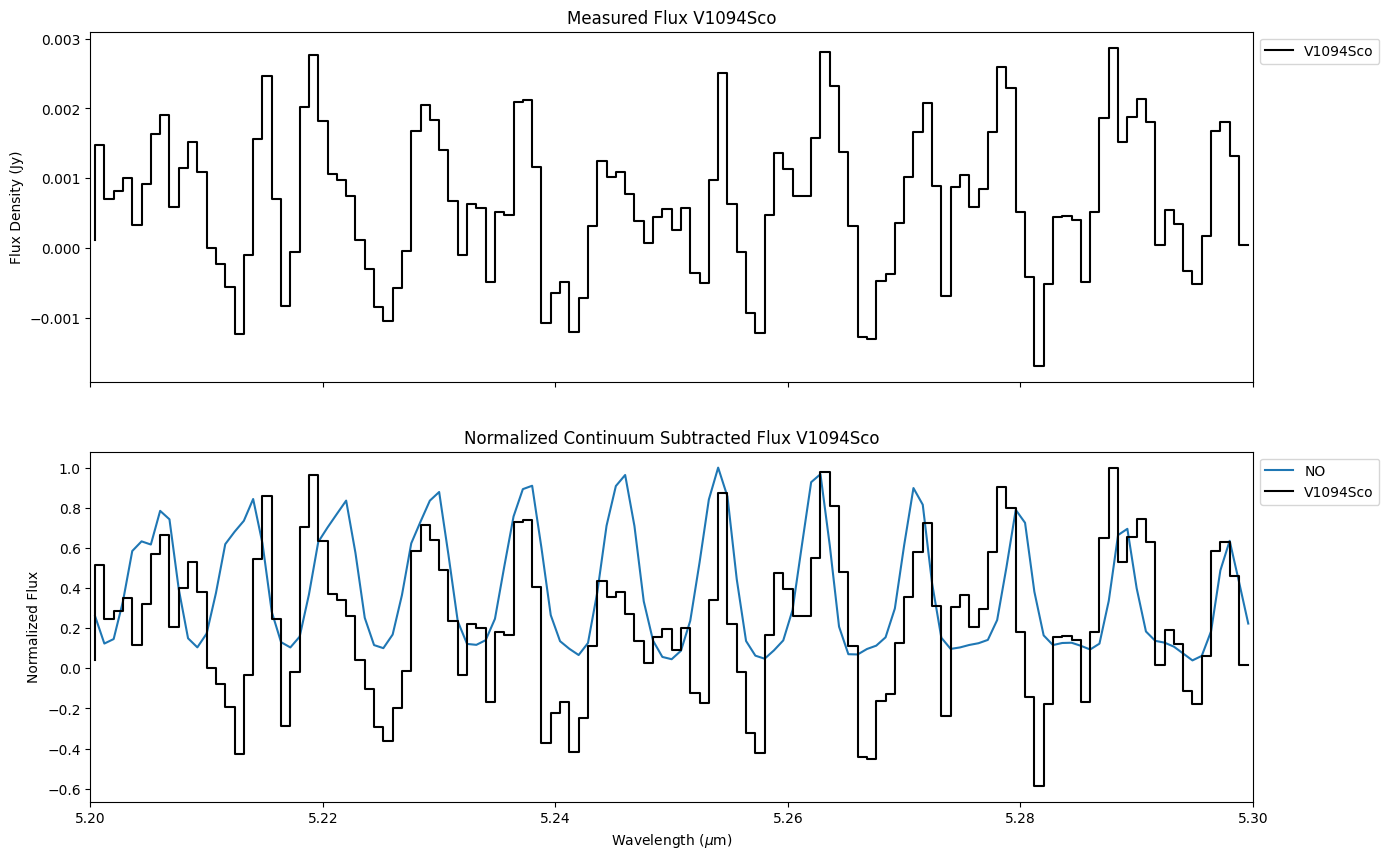

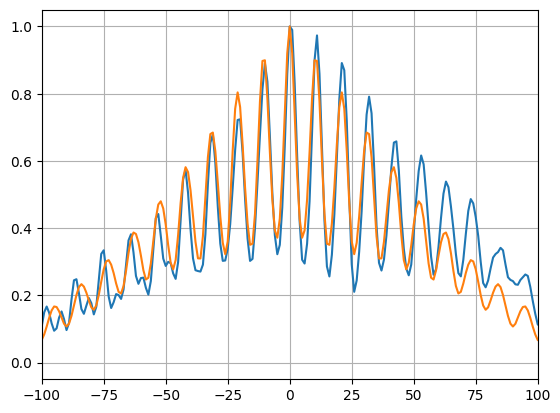

PearsonRResult(statistic=np.float64(0.9461330535681576), pvalue=np.float64(5.7559130340547936e-123))


In [203]:
from scipy.optimize import minimize

clip_min, clip_max = 5.2, 5.3
feature_mask = np.logical_and(total_wl > clip_min, total_wl < clip_max)

species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
# species = ['C2H2', 'H2O', 'HCN', 'NH3', 'OH']
species = ['NO']
def model(params):
    total = np.zeros_like(total_wl)
    for i, specie in enumerate(species):
        total += params[i] * avg_flux[specie]
    # total += params[-1]
    return total


def loss(params):
    if any(param < 0 for param in params):
        return 1e10
    return np.sum((model(params) - flux_cont_sub)[feature_mask] ** 2)

target = 'NO'

for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']

    result = minimize(loss, [.1]*(len(species)))
    best_params = result.x
    # print(best_params)
    y_fit = model(best_params)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    # plt.figure(figsize=(15, 5))
    # ax1.plot(wavelength, model(best_params), color='red')
    # for i, specie in enumerate(species):
    #     ax1.plot(total_wl[feature_mask], best_params[i]*avg_flux[specie][feature_mask], alpha=0.7, label=specie)
    ax1.step(wavelength[feature_mask], flux_cont_sub[feature_mask], color='black', label=Source)
    ax1.set_xlim(clip_min, clip_max)
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_title(f'Measured Flux {Source}')
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # plt.show()
    # plt.figure(figsize=(15, 5))
    for specie in species:
        ax2.plot(total_wl[feature_mask], avg_flux[specie][feature_mask]/max(avg_flux[specie][feature_mask]), label=specie)
    ax2.step(wavelength[feature_mask], flux_cont_sub[feature_mask]/max(flux_cont_sub[feature_mask]), color='black', label=Source)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.set_xlabel(r'Wavelength ($\mu$m)')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_title(f'Normalized Continuum Subtracted Flux {Source}')
    plt.show()
    cc = fftconvolve((flux_cont_sub[feature_mask]), (avg_flux[target][feature_mask])[::-1], mode='full')
    ac_specie = fftconvolve((avg_flux[target][feature_mask]), (avg_flux[target][feature_mask])[::-1], mode='full')
    ac_total = fftconvolve((flux_cont_sub[feature_mask]), (flux_cont_sub[feature_mask])[::-1], mode='full')
    lags = np.arange(-len(flux_cont_sub[feature_mask]) + 1, len(avg_flux[target][feature_mask]))
    plt.plot(lags, cc/cc[lags==0])
    plt.plot(lags, ac_specie/ac_specie[lags==0])
    plt.xlim(-100, 100)
    plt.grid()
    plt.show()
    print(pearsonr(cc, ac_specie))

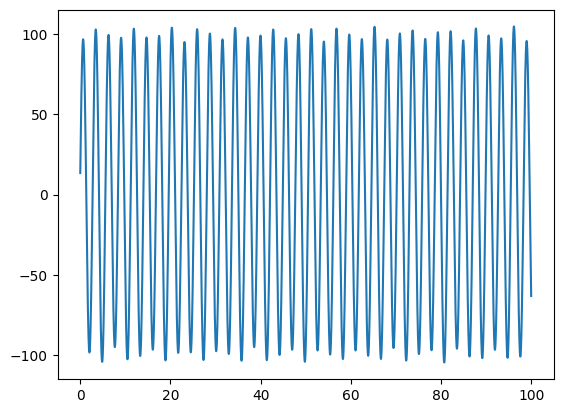

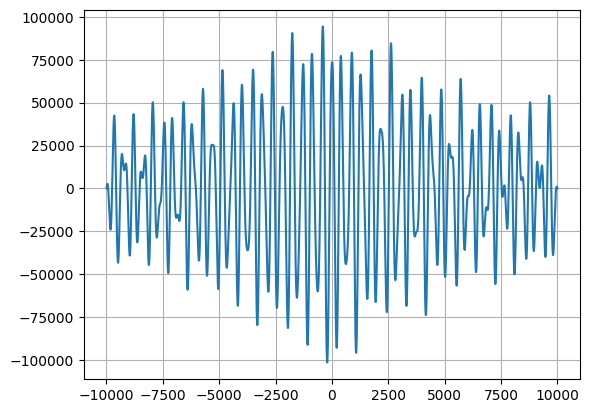

In [171]:
time = np.linspace(0, 100, 10000)
signal = 100*np.sin(np.sqrt(5) * time+0.15) + np.random.randn(len(time))*0
tiny_signal = np.sin(time+0.1)+ 4*np.sin(np.sqrt(2) * time-9)
signal += tiny_signal
plt.plot(time, signal)
plt.show()
cc = fftconvolve(tiny_signal, signal[::-1], mode='full')
lags = np.arange(-len(signal) + 1, len(signal))
plt.plot(lags, cc)
# plt.xlim(-100, 100)
plt.grid()

In [172]:
import numpy as np

def cross_correlation_sn(cross_corr, peak_region_width=5):
    # Find maximum peak
    peak_index = np.argmax(cross_corr)
    peak_value = cross_corr[peak_index]

    # Mask out a region around the peak (to not bias noise estimate)
    mask = np.ones_like(cross_corr, dtype=bool)
    mask[max(0, peak_index - peak_region_width): peak_index + peak_region_width + 1] = False

    # Noise = std of the baseline
    noise_std = np.std(cross_corr[mask])

    # Signal-to-noise ratio
    sn_ratio = peak_value / noise_std
    return sn_ratio

# Example usage:
# cross_corr = your cross-correlation array
# sn = cross_correlation_sn(cross_corr)
# print(f"Signal-to-noise ratio: {sn:.2f}")

In [175]:
def random_shuffle_fap(flux, template, num_trials=1000):
    random_peaks = []

    for _ in range(num_trials):
        shuffled_flux = np.random.permutation(flux)
        cc = fftconvolve(shuffled_flux, template[::-1], mode='same')
        max_peak = np.max(cc)
        random_peaks.append(max_peak)

    return np.array(random_peaks)

# Example usage:
# random_peaks = random_shuffle_fap(flux, template)
# fap = np.mean(random_peaks >= your_real_peak_value)
# print(f"False Alarm Probability: {fap:.5f}")


In [178]:
# Assume you have flux and template
cc_real = np.correlate(flux_cont_sub[feature_mask], avg_flux[target][feature_mask], mode='same')

# Step 1: Calculate S/N
sn = cross_correlation_sn(cc_real, peak_region_width=20)
print(f"S/N of real cross-correlation peak: {sn:.2f}")

# Step 2: Calculate FAP
real_peak = np.max(cc_real)
random_peaks = random_shuffle_fap(flux_cont_sub[feature_mask], avg_flux[target][feature_mask], num_trials=1000)
fap = np.mean(random_peaks >= real_peak)
print(f"False Alarm Probability (FAP): {fap:.5f}")


S/N of real cross-correlation peak: 6.20
False Alarm Probability (FAP): 0.01100
